# Unet Cell Segmentation

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
use_gpu = torch.cuda.is_available()

# Data Preperation

In [2]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
width_out = 128
height_out = 128
TRAIN_PATH = './train/'
TEST_PATH = './test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
# Get and resize train images and masks
x_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_train = np.zeros((len(train_ids), height_out, width_out, 1), dtype=np.bool)

# Get and resize train images
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_train[n] = img
    mask = np.zeros((height_out, width_out, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (height_out, width_out), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    y_train[n] = mask

# Get and resize test images
x_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


C:\Users\lashl\AppData\Local\Temp/ipykernel_13456/2597570701.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.zeros((len(train_ids), height_out, width_out, 1), dtype=np.bool)
  0%|                                                                                          | 0/670 [00:00<?, ?it/s]C:\Users\lashl\AppData\Local\Temp/ipykernel_13456/2597570701.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and gui

Getting and resizing test images ... 



100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 59.64it/s]

Done!


In [4]:
x_train.shape, y_train.shape, x_test.shape

((670, 128, 128, 3), (670, 128, 128, 1), (65, 128, 128, 3))

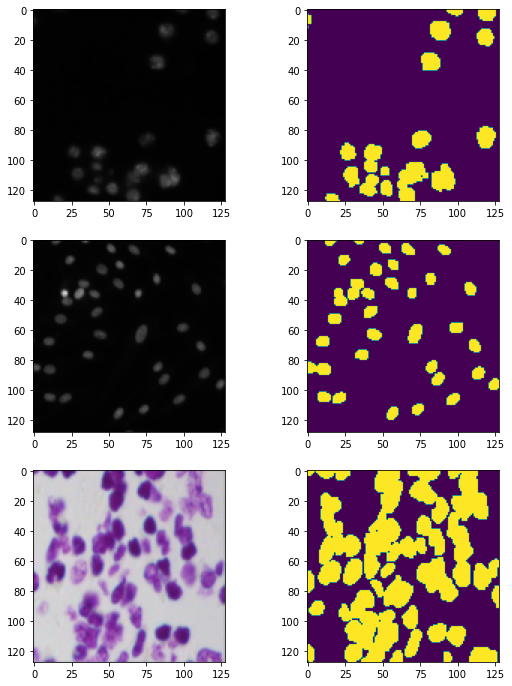

In [5]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(9,12))
ax[0][0].imshow(x_train[0])
ax[0][1].imshow(np.squeeze(y_train[0]))
ax[1][0].imshow(x_train[1])
ax[1][1].imshow(np.squeeze(y_train[1]))
ax[2][0].imshow(x_train[2])
ax[2][1].imshow(np.squeeze(y_train[2]))

In [6]:
x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size=0.25)

In [7]:
x_train = x_train.transpose((0,3,1,2))
y_train = y_train.transpose((0,3,1,2))
x_val = x_val.transpose((0,3,1,2))
y_val = y_val.transpose((0,3,1,2))
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((502, 3, 128, 128),
 (502, 1, 128, 128),
 (168, 3, 128, 128),
 (168, 1, 128, 128))

In [3]:
#np.save('./x_train',x_train,allow_pickle =False)
#np.save('./x_val',x_val,allow_pickle =False)
#np.save('./y_train',y_train,allow_pickle =False)
#np.save('./y_val',y_train,allow_pickle =False)
x_train = np.load('./x_train.npy', mmap_mode='r')
x_val = np.load('./x_val.npy', mmap_mode='r')
y_train = np.load('./y_train.npy', mmap_mode='r')
y_val = np.load('./y_val.npy', mmap_mode='r')

# Model Architecture

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class BrokenUp(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x2 = torch.zeros(size=x1.size(),device='cuda')
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    
class BrokenUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(BrokenUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = BrokenUp(1024, 512 // factor, bilinear)
        self.up2 = BrokenUp(512, 256 // factor, bilinear)
        self.up3 = BrokenUp(256, 128 // factor, bilinear)
        self.up4 = BrokenUp(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Hyperparameters

In [5]:
model = UNet(n_channels=3,n_classes=2)
if use_gpu:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)
batch_size = 10
epochs = 80
epoch_lapse = 1

In [6]:
def get_val_loss(x_val, y_val, batch_size=batch_size):
    epoch_iter = np.ceil(x_val.shape[0] / batch_size).astype(int)
    for _ in range(epoch_iter):
        total_loss = 0
        for i in range(epoch_iter):
            batch_val_x = torch.from_numpy(x_val[i * batch_size : (i + 1) * batch_size]).float()
            batch_val_y = torch.from_numpy(y_val[i * batch_size : (i + 1) * batch_size].astype(int)).long()
            if use_gpu:
                batch_val_x = batch_train_x.cuda()
                batch_val_y = batch_train_y.cuda()
            m = batch_val_x.shape[0]
            outputs = model(batch_val_x)
            outputs = outputs.permute(0, 2, 3, 1)
            outputs = outputs.reshape(m*width_out*height_out, 2)
            labels = batch_val_y.reshape(m*width_out*height_out)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.data
            gc.collect()
    return total_loss / epoch_iter

In [7]:
def train_script(inputs, labels, optimizer, criterion, batch_size):
    optimizer.zero_grad()
    outputs = model(inputs)
    outputs = outputs.permute(0, 2, 3, 1)
    outputs = outputs.reshape(batch_size*width_out*height_out, 2)
    labels = labels.reshape(batch_size*width_out*height_out)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [8]:
eval_list = []
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
t = trange(epochs, leave=True)

for _ in t:
    total_loss = 0
    for i in range(epoch_iter):
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size].astype(int)).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_script(batch_train_x , batch_train_y, optimizer, criterion, batch_train_x.shape[0])
        total_loss += batch_loss
        gc.collect()
        
    if (_+1) % epoch_lapse == 0:
        val_loss = get_val_loss(x_val, y_val)

        eval_list.append([_+1, 
                          total_loss/epoch_iter,
                          val_loss]) 

        print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

eval_df = pd.DataFrame(eval_list, columns=["epoch", "train_loss",
                                              "valid_loss"])

  0%|                                                                                           | 0/80 [00:00<?, ?it/s]C:\Users\lashl\AppData\Local\Temp/ipykernel_6692/3410831272.py:8: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
  1%|█                                                                                  | 1/80 [00:19<26:04, 19.80s/it]

Total loss in epoch 1 : 0.3653477728366852 and validation loss : 0.2887236177921295


  2%|██                                                                                 | 2/80 [00:38<25:09, 19.36s/it]

Total loss in epoch 2 : 0.22378146648406982 and validation loss : 0.21826666593551636


  4%|███                                                                                | 3/80 [00:57<24:36, 19.18s/it]

Total loss in epoch 3 : 0.18031325936317444 and validation loss : 0.18527834117412567


  5%|████▏                                                                              | 4/80 [01:15<23:31, 18.58s/it]

Total loss in epoch 4 : 0.15626993775367737 and validation loss : 0.16219225525856018


  6%|█████▏                                                                             | 5/80 [01:32<22:38, 18.11s/it]

Total loss in epoch 5 : 0.13823741674423218 and validation loss : 0.146677166223526


  8%|██████▏                                                                            | 6/80 [01:50<22:06, 17.93s/it]

Total loss in epoch 6 : 0.12562701106071472 and validation loss : 0.13037386536598206


  9%|███████▎                                                                           | 7/80 [02:07<21:31, 17.69s/it]

Total loss in epoch 7 : 0.11605775356292725 and validation loss : 0.12558187544345856


 10%|████████▎                                                                          | 8/80 [02:25<21:30, 17.92s/it]

Total loss in epoch 8 : 0.11054989695549011 and validation loss : 0.11022735387086868


 11%|█████████▎                                                                         | 9/80 [02:44<21:33, 18.21s/it]

Total loss in epoch 9 : 0.10167976468801498 and validation loss : 0.10171337425708771


 12%|██████████▎                                                                       | 10/80 [03:03<21:30, 18.44s/it]

Total loss in epoch 10 : 0.09634072333574295 and validation loss : 0.09426268190145493


 14%|███████████▎                                                                      | 11/80 [03:22<21:26, 18.64s/it]

Total loss in epoch 11 : 0.09137099981307983 and validation loss : 0.08654571324586868


 15%|████████████▎                                                                     | 12/80 [03:41<21:16, 18.77s/it]

Total loss in epoch 12 : 0.08912768214941025 and validation loss : 0.08066750317811966


 16%|█████████████▎                                                                    | 13/80 [04:01<21:06, 18.91s/it]

Total loss in epoch 13 : 0.08440184593200684 and validation loss : 0.07424188405275345


 18%|██████████████▎                                                                   | 14/80 [04:20<20:52, 18.97s/it]

Total loss in epoch 14 : 0.08134184777736664 and validation loss : 0.06922607123851776


 19%|███████████████▍                                                                  | 15/80 [04:39<20:39, 19.07s/it]

Total loss in epoch 15 : 0.09007463604211807 and validation loss : 0.09221915900707245


 20%|████████████████▍                                                                 | 16/80 [04:59<20:28, 19.19s/it]

Total loss in epoch 16 : 0.0828288272023201 and validation loss : 0.07196874916553497


 21%|█████████████████▍                                                                | 17/80 [05:18<20:12, 19.25s/it]

Total loss in epoch 17 : 0.0767904594540596 and validation loss : 0.06520699709653854


 22%|██████████████████▍                                                               | 18/80 [05:37<19:53, 19.25s/it]

Total loss in epoch 18 : 0.07409654557704926 and validation loss : 0.059101637452840805


 24%|███████████████████▍                                                              | 19/80 [05:56<19:35, 19.27s/it]

Total loss in epoch 19 : 0.07123398780822754 and validation loss : 0.05412411317229271


 25%|████████████████████▌                                                             | 20/80 [06:16<19:17, 19.29s/it]

Total loss in epoch 20 : 0.06880602985620499 and validation loss : 0.051122430711984634


 26%|█████████████████████▌                                                            | 21/80 [06:37<19:24, 19.74s/it]

Total loss in epoch 21 : 0.06683865189552307 and validation loss : 0.048681553453207016


 28%|██████████████████████▌                                                           | 22/80 [06:56<18:54, 19.56s/it]

Total loss in epoch 22 : 0.07277663052082062 and validation loss : 0.058974966406822205


 29%|███████████████████████▌                                                          | 23/80 [07:15<18:29, 19.47s/it]

Total loss in epoch 23 : 0.06607231497764587 and validation loss : 0.047291819006204605


 30%|████████████████████████▌                                                         | 24/80 [07:35<18:18, 19.61s/it]

Total loss in epoch 24 : 0.06311856955289841 and validation loss : 0.042881209403276443


 31%|█████████████████████████▋                                                        | 25/80 [07:55<18:01, 19.66s/it]

Total loss in epoch 25 : 0.06006874144077301 and validation loss : 0.03977807238698006


 32%|██████████████████████████▋                                                       | 26/80 [08:14<17:29, 19.43s/it]

Total loss in epoch 26 : 0.05761414021253586 and validation loss : 0.03695106878876686


 34%|███████████████████████████▋                                                      | 27/80 [08:33<17:04, 19.33s/it]

Total loss in epoch 27 : 0.05616383254528046 and validation loss : 0.03515961393713951


 35%|████████████████████████████▋                                                     | 28/80 [08:52<16:40, 19.24s/it]

Total loss in epoch 28 : 0.05842437967658043 and validation loss : 0.03637402504682541


 36%|█████████████████████████████▋                                                    | 29/80 [09:11<16:18, 19.19s/it]

Total loss in epoch 29 : 0.055085230618715286 and validation loss : 0.035010926425457


 38%|██████████████████████████████▊                                                   | 30/80 [09:31<16:09, 19.39s/it]

Total loss in epoch 30 : 0.05216793715953827 and validation loss : 0.03159589320421219


 39%|███████████████████████████████▊                                                  | 31/80 [09:50<15:48, 19.36s/it]

Total loss in epoch 31 : 0.050687871873378754 and validation loss : 0.031832221895456314


 40%|████████████████████████████████▊                                                 | 32/80 [10:10<15:37, 19.54s/it]

Total loss in epoch 32 : 0.04947898909449577 and validation loss : 0.027833158150315285


 41%|█████████████████████████████████▊                                                | 33/80 [10:31<15:39, 19.98s/it]

Total loss in epoch 33 : 0.04870050773024559 and validation loss : 0.02969300001859665


 42%|██████████████████████████████████▊                                               | 34/80 [10:52<15:31, 20.25s/it]

Total loss in epoch 34 : 0.05077457055449486 and validation loss : 0.029121428728103638


 44%|███████████████████████████████████▉                                              | 35/80 [11:11<14:55, 19.90s/it]

Total loss in epoch 35 : 0.04891466721892357 and validation loss : 0.029964594170451164


 45%|████████████████████████████████████▉                                             | 36/80 [11:30<14:31, 19.81s/it]

Total loss in epoch 36 : 0.04622196778655052 and validation loss : 0.02547457069158554


 46%|█████████████████████████████████████▉                                            | 37/80 [11:51<14:14, 19.88s/it]

Total loss in epoch 37 : 0.044548504054546356 and validation loss : 0.02325102500617504


 48%|██████████████████████████████████████▉                                           | 38/80 [12:10<13:47, 19.71s/it]

Total loss in epoch 38 : 0.04122600331902504 and validation loss : 0.02112462930381298


 49%|███████████████████████████████████████▉                                          | 39/80 [12:29<13:18, 19.48s/it]

Total loss in epoch 39 : 0.03979484364390373 and validation loss : 0.020171236246824265


 50%|█████████████████████████████████████████                                         | 40/80 [12:48<12:52, 19.32s/it]

Total loss in epoch 40 : 0.037913087755441666 and validation loss : 0.019020935520529747


 51%|██████████████████████████████████████████                                        | 41/80 [13:07<12:28, 19.19s/it]

Total loss in epoch 41 : 0.0368574783205986 and validation loss : 0.019425150007009506


 52%|███████████████████████████████████████████                                       | 42/80 [13:26<12:06, 19.11s/it]

Total loss in epoch 42 : 0.03626013919711113 and validation loss : 0.018616382032632828


 54%|████████████████████████████████████████████                                      | 43/80 [13:45<11:48, 19.15s/it]

Total loss in epoch 43 : 0.03505495935678482 and validation loss : 0.018225761130452156


 55%|█████████████████████████████████████████████                                     | 44/80 [14:04<11:34, 19.28s/it]

Total loss in epoch 44 : 0.03394554555416107 and validation loss : 0.016242701560258865


 56%|██████████████████████████████████████████████▏                                   | 45/80 [14:25<11:25, 19.58s/it]

Total loss in epoch 45 : 0.03336532041430473 and validation loss : 0.016627835109829903


 57%|███████████████████████████████████████████████▏                                  | 46/80 [14:44<11:06, 19.60s/it]

Total loss in epoch 46 : 0.03237159177660942 and validation loss : 0.01646912470459938


 59%|████████████████████████████████████████████████▏                                 | 47/80 [15:03<10:40, 19.41s/it]

Total loss in epoch 47 : 0.031134797260165215 and validation loss : 0.01445032935589552


 60%|█████████████████████████████████████████████████▏                                | 48/80 [15:22<10:19, 19.35s/it]

Total loss in epoch 48 : 0.02978873811662197 and validation loss : 0.013449921272695065


 61%|██████████████████████████████████████████████████▏                               | 49/80 [15:42<09:57, 19.27s/it]

Total loss in epoch 49 : 0.03158694505691528 and validation loss : 0.014331147074699402


 62%|███████████████████████████████████████████████████▎                              | 50/80 [16:01<09:36, 19.22s/it]

Total loss in epoch 50 : 0.030399929732084274 and validation loss : 0.014814168214797974


 64%|████████████████████████████████████████████████████▎                             | 51/80 [16:20<09:19, 19.28s/it]

Total loss in epoch 51 : 0.02707860805094242 and validation loss : 0.012379567138850689


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [16:39<08:56, 19.15s/it]

Total loss in epoch 52 : 0.02602430246770382 and validation loss : 0.010782917030155659


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [16:59<08:42, 19.34s/it]

Total loss in epoch 53 : 0.025932271033525467 and validation loss : 0.011654689908027649


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [17:18<08:23, 19.38s/it]

Total loss in epoch 54 : 0.026267701759934425 and validation loss : 0.012159048579633236


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [17:38<08:11, 19.65s/it]

Total loss in epoch 55 : 0.02519277110695839 and validation loss : 0.01101213600486517


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [17:58<07:52, 19.69s/it]

Total loss in epoch 56 : 0.024256631731987 and validation loss : 0.009572142735123634


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [18:18<07:32, 19.69s/it]

Total loss in epoch 57 : 0.02351820468902588 and validation loss : 0.009911121800541878


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [18:38<07:14, 19.74s/it]

Total loss in epoch 58 : 0.024511165916919708 and validation loss : 0.009322909638285637


 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [18:58<06:58, 19.93s/it]

Total loss in epoch 59 : 0.024281352758407593 and validation loss : 0.009571770206093788


 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [19:19<06:41, 20.09s/it]

Total loss in epoch 60 : 0.023323768749833107 and validation loss : 0.00894314143806696


 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [19:39<06:21, 20.09s/it]

Total loss in epoch 61 : 0.02223203144967556 and validation loss : 0.008940090425312519


 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [19:59<06:00, 20.03s/it]

Total loss in epoch 62 : 0.024328108876943588 and validation loss : 0.009759211912751198


 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [20:18<05:36, 19.77s/it]

Total loss in epoch 63 : 0.02074633166193962 and validation loss : 0.009016589261591434


 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [20:38<05:16, 19.81s/it]

Total loss in epoch 64 : 0.019390935078263283 and validation loss : 0.009932821616530418


 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [20:57<04:55, 19.67s/it]

Total loss in epoch 65 : 0.018588336184620857 and validation loss : 0.007995383813977242


 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [21:16<04:34, 19.59s/it]

Total loss in epoch 66 : 0.020613521337509155 and validation loss : 0.0076878913678228855


 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [21:36<04:15, 19.63s/it]

Total loss in epoch 67 : 0.020245376974344254 and validation loss : 0.0071223098784685135


 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [21:56<03:56, 19.70s/it]

Total loss in epoch 68 : 0.019583407789468765 and validation loss : 0.00746742682531476


 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [22:16<03:38, 19.89s/it]

Total loss in epoch 69 : 0.019476255401968956 and validation loss : 0.007447161246091127


 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [22:36<03:18, 19.83s/it]

Total loss in epoch 70 : 0.01816740445792675 and validation loss : 0.006572381127625704


 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [22:57<03:00, 20.10s/it]

Total loss in epoch 71 : 0.016642456874251366 and validation loss : 0.005998106673359871


 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [23:17<02:42, 20.28s/it]

Total loss in epoch 72 : 0.015253528952598572 and validation loss : 0.0060373330488801


 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [23:37<02:21, 20.17s/it]

Total loss in epoch 73 : 0.015191140584647655 and validation loss : 0.0053711384534835815


 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [23:57<01:59, 19.98s/it]

Total loss in epoch 74 : 0.015514618717133999 and validation loss : 0.005593699868768454


 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [24:17<01:39, 19.88s/it]

Total loss in epoch 75 : 0.014873746782541275 and validation loss : 0.005453141871839762


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [24:36<01:18, 19.74s/it]

Total loss in epoch 76 : 0.015126108191907406 and validation loss : 0.004830042831599712


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [24:55<00:58, 19.65s/it]

Total loss in epoch 77 : 0.014464201405644417 and validation loss : 0.004656623117625713


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [25:15<00:39, 19.73s/it]

Total loss in epoch 78 : 0.014239173382520676 and validation loss : 0.004588439129292965


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [25:36<00:19, 19.88s/it]

Total loss in epoch 79 : 0.013622594997286797 and validation loss : 0.005176135338842869


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [25:56<00:00, 19.45s/it]

Total loss in epoch 80 : 0.014507829211652279 and validation loss : 0.004602000117301941


<AxesSubplot:title={'center':'Unet Cross-Entropy Loss'}, xlabel='Epochs', ylabel='Cross-Entropy Loss'>

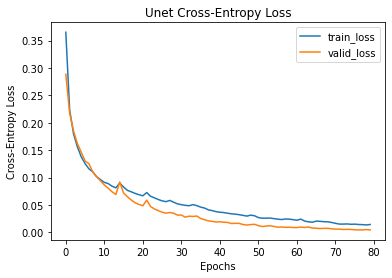

In [9]:
plot_list = []

for item in eval_list:
    plot_list.append([item[0],
                      item[1].item(),
                      item[2].item()
                      ])

plot_df = pd.DataFrame(plot_list, columns=["epoch", "train_loss",
                                              "valid_loss"])

plot_df[["train_loss","valid_loss"]].plot(title='"Broken" Unet Cross-Entropy Loss',
                                            xlabel='Epochs',
                                            ylabel='Cross-Entropy Loss')

In [14]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = model(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.squeeze((image_arr > 0.40)[1,:,:].astype(int)))
        ax[row_num][1].set_title("Generated Mask")
        ax[row_num][2].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][2].set_title("Ground Truth")
    plt.show()

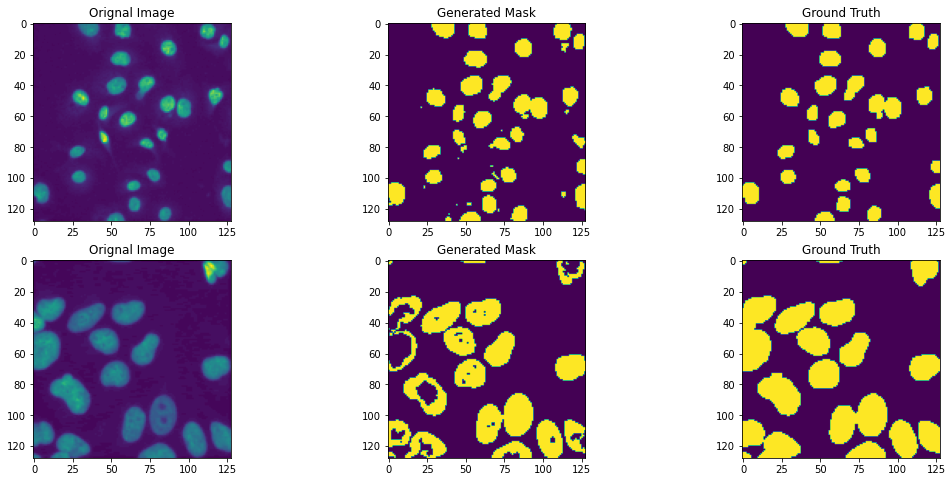

In [16]:
plot_examples(x_train, y_train, 2)

In [ ]:
#torch.save(model.state_dict(), './unet_full01')